We will start by reviewing Linear Models, since they are likely already familiar to you from prior coursework, are widely used, and will serve as a useful (if simple) launching off point for later discussions of more advanced techniques. So, while some of what we will explore in this section might seem pretty basic at first glance, do not let it's simplicity fool you, as we will revisit similar concepts throughout the rest of the notes, as these concepts will help you form a strong foundation that will serve us well once things get more complex.

This chapter will do this in three parts:

1. Review the basic setup of a linear model, including notation and how adding features to the linear model can make it behave in ways that would appear "non-linear".
2. Review the concept of Regularization --- which will essentially penalize model complexity to avoid overfitting.
3. Discuss different types of commonly used loss functions for linear models, demonstrating their differences and possible use cases.

With this as a baseline model, the next chapter will review the concept of Cross-Validation and how we evaluate whether an Machine Learning model is "good", and then the subsequent chapter will review (Stochastic) Gradient Descent, in the Linear Model context.

## What is a Linear Model?

Let's start by trying to fit a model to the (admittedly simple) dataset below, where I have just sampled some (noisy) points from a periodic function:

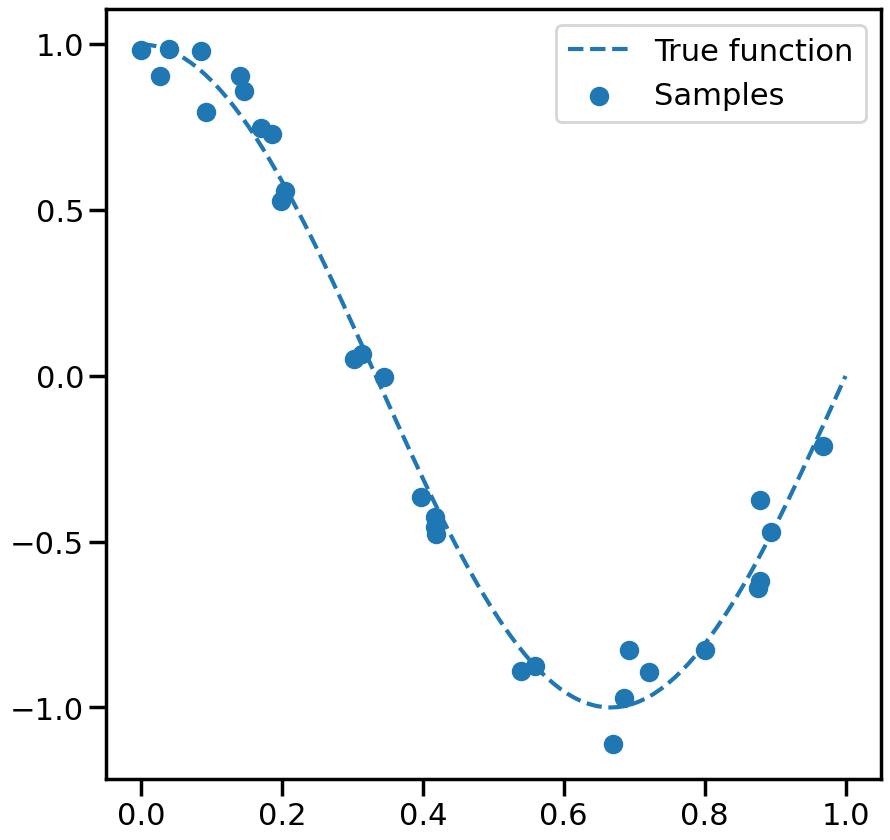

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from ipywidgets import interact,interact_manual, FloatSlider
from sklearn.datasets import make_regression
import seaborn as sns
sns.set_context('poster')
np.random.seed(1)

# Number of data points
n_samples = 30

# True Function we want to estimate
true_fun = lambda X: np.cos(1.5 * np.pi * X)

# Noisy Samples from the true function
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(10,10))
# Plot the true function:
X_plot = np.linspace(0, 1, 100)
plt.plot(X_plot, true_fun(X_plot), '--',label="True function")
# Plot the data samples
plt.scatter(X,y, label="Samples")
plt.legend(loc="best")
plt.show()

If we wanted to fit a line to this data, we would use what is called a linear model:

$$
y = w_0+w_1\cdot x
$$

where $w_0$ is the intercept and $w_1$ is the slope of the line. We can write this more compactly using vector notation as:
$$
y = \mathbf{w}^T \mathbf{x}
$$
where w is the weight vector [$w_0$, $w_1$] and $x$ is the feature vector [1, x]. We can see here that taking the dot product between $w$ and $x$ is equivalent to the equation above. Importantly, even though the above equation represents a straight line with respect to x, we are not limited to using linear models only for this. For example, we could make:

$$
\mathbf{w} = [w_0, w_1, w_2, w_3];\quad \mathbf{x} = [1, x, x^2, x^3]
$$

and in this way, we can model y as a cubic function of x, while $y = \mathbf{w}^T \mathbf{x}$ remains a "linear model", since it is still linear with respect to the weights $w$. This is quite powerful, since by adding features (i.e., additional concatentated entries) to $\mathbf{x}$, we can fit functions that are apparently non-linear with respect to the original input variable $x$, but will possess many useful properties of linear models that we will discuss later (e.g., convexity with respect to $w$).

In [2]:
#| echo: false
#| output: false
# This code cell just shows how to pull out the values of X
# Just for the purposes of display, set the print precision to 2 decimals
%precision 2
X[:, np.newaxis]

array([[1.14e-04],
       [2.74e-02],
       [3.91e-02],
       [8.50e-02],
       [9.23e-02],
       [1.40e-01],
       [1.47e-01],
       [1.70e-01],
       [1.86e-01],
       [1.98e-01],
       [2.04e-01],
       [3.02e-01],
       [3.13e-01],
       [3.46e-01],
       [3.97e-01],
       [4.17e-01],
       [4.17e-01],
       [4.19e-01],
       [5.39e-01],
       [5.59e-01],
       [6.70e-01],
       [6.85e-01],
       [6.92e-01],
       [7.20e-01],
       [8.01e-01],
       [8.76e-01],
       [8.78e-01],
       [8.78e-01],
       [8.95e-01],
       [9.68e-01]])

In [3]:
#| echo: false
#| output: false
# This code cell just shows how we can augment X with additional Polynomial features
# Let's build some Polynomial features:
d=3
pfeatures = PolynomialFeatures(degree=d,include_bias=False)
pfeatures.fit_transform(X[:, np.newaxis])

array([[1.14e-04, 1.31e-08, 1.50e-12],
       [2.74e-02, 7.50e-04, 2.05e-05],
       [3.91e-02, 1.53e-03, 5.96e-05],
       [8.50e-02, 7.23e-03, 6.15e-04],
       [9.23e-02, 8.53e-03, 7.87e-04],
       [1.40e-01, 1.97e-02, 2.77e-03],
       [1.47e-01, 2.15e-02, 3.16e-03],
       [1.70e-01, 2.88e-02, 4.90e-03],
       [1.86e-01, 3.47e-02, 6.46e-03],
       [1.98e-01, 3.92e-02, 7.77e-03],
       [2.04e-01, 4.18e-02, 8.55e-03],
       [3.02e-01, 9.14e-02, 2.76e-02],
       [3.13e-01, 9.82e-02, 3.08e-02],
       [3.46e-01, 1.19e-01, 4.13e-02],
       [3.97e-01, 1.57e-01, 6.25e-02],
       [4.17e-01, 1.74e-01, 7.25e-02],
       [4.17e-01, 1.74e-01, 7.27e-02],
       [4.19e-01, 1.76e-01, 7.37e-02],
       [5.39e-01, 2.90e-01, 1.56e-01],
       [5.59e-01, 3.12e-01, 1.74e-01],
       [6.70e-01, 4.50e-01, 3.01e-01],
       [6.85e-01, 4.70e-01, 3.22e-01],
       [6.92e-01, 4.79e-01, 3.32e-01],
       [7.20e-01, 5.19e-01, 3.74e-01],
       [8.01e-01, 6.41e-01, 5.13e-01],
       [8.76e-01, 7.68e-0

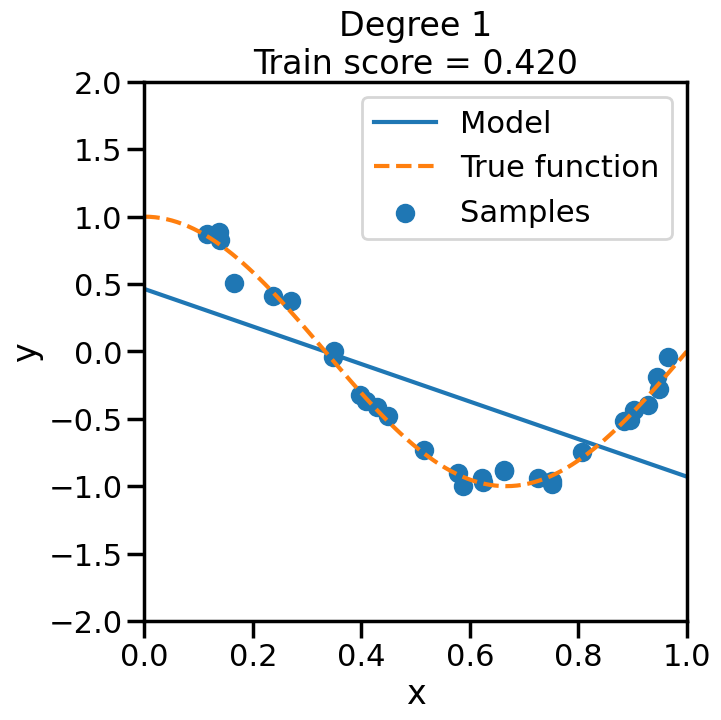

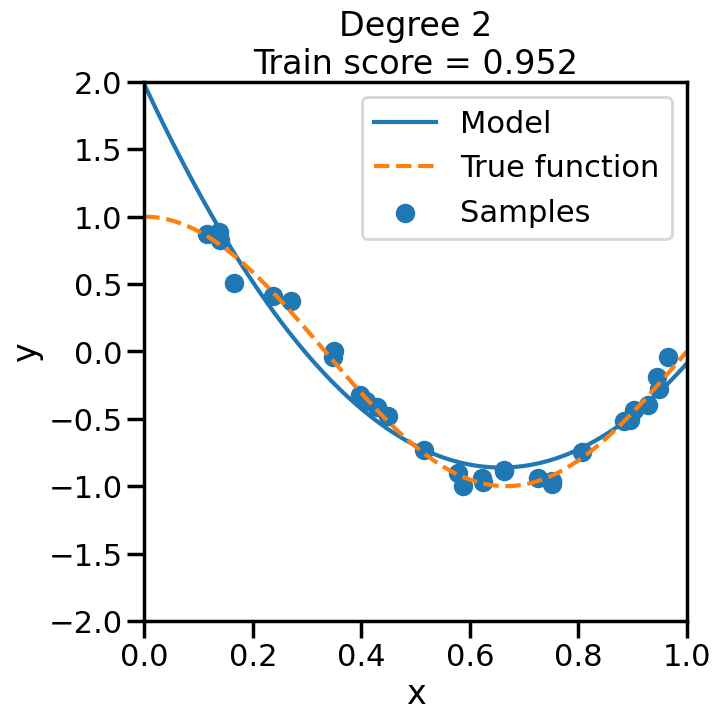

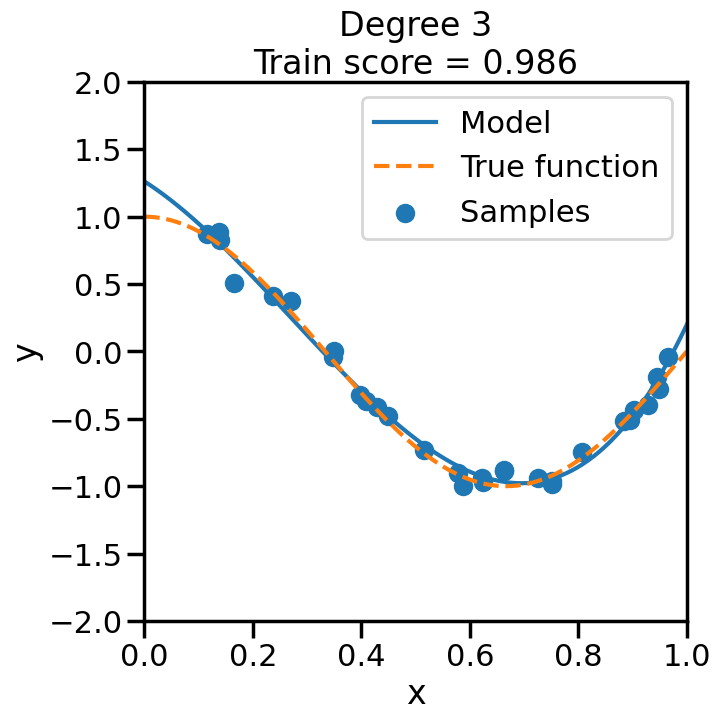

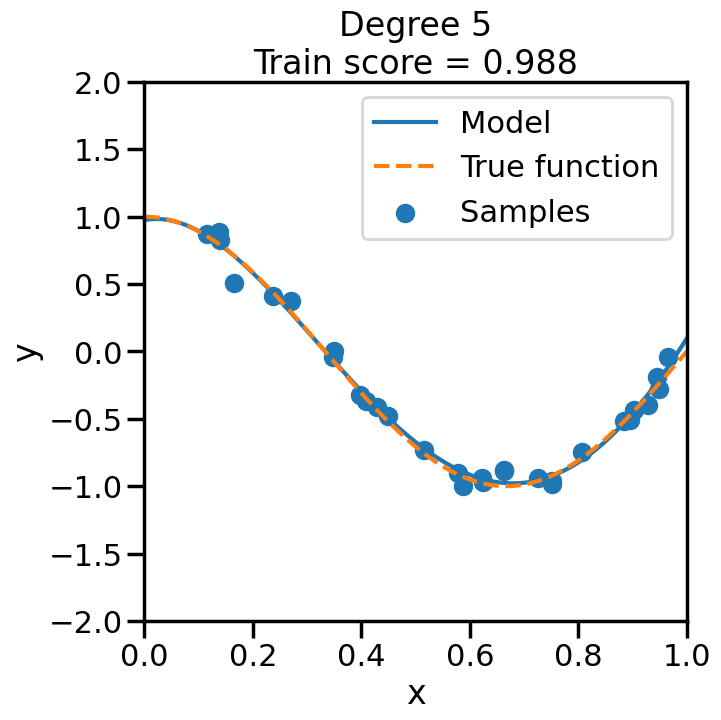

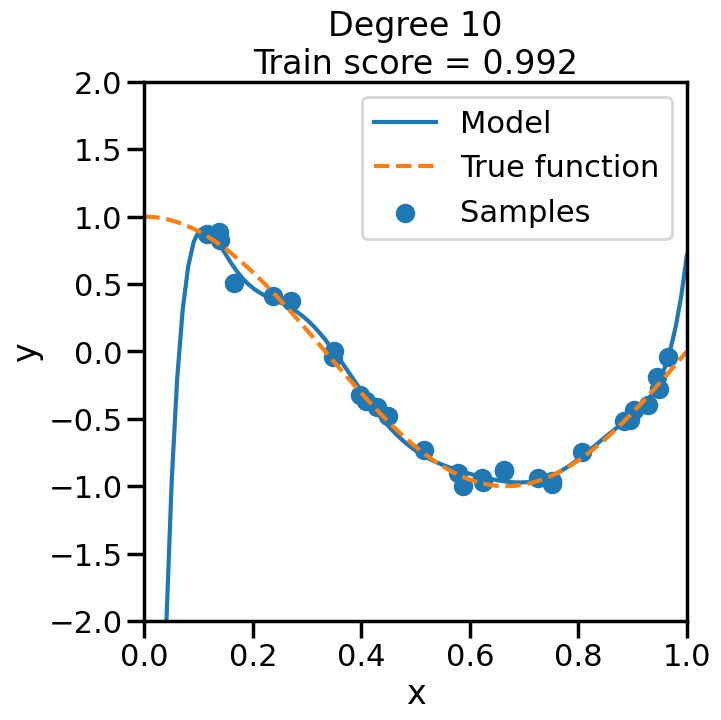

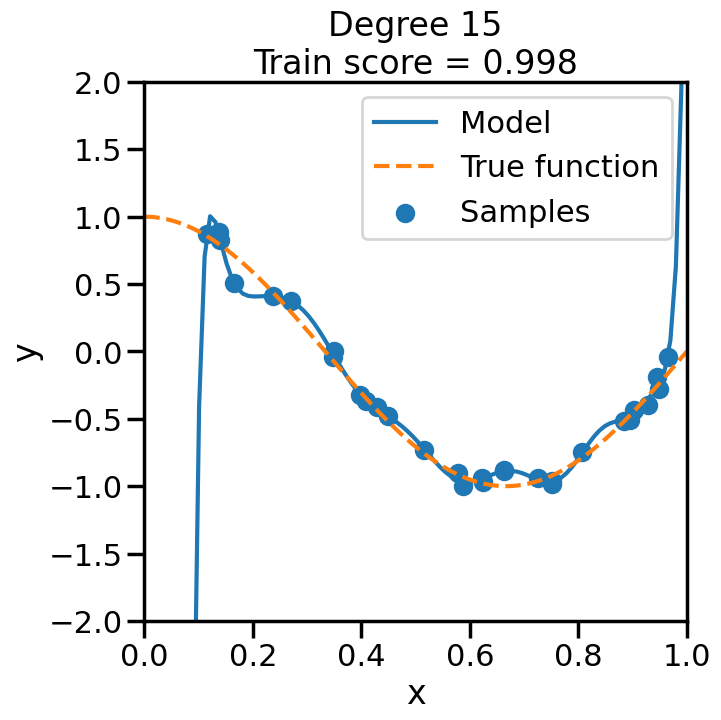

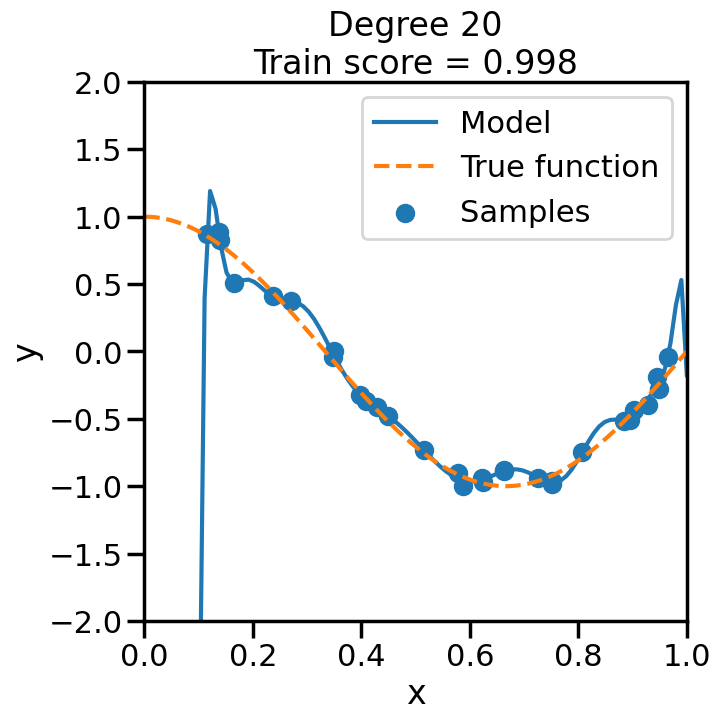

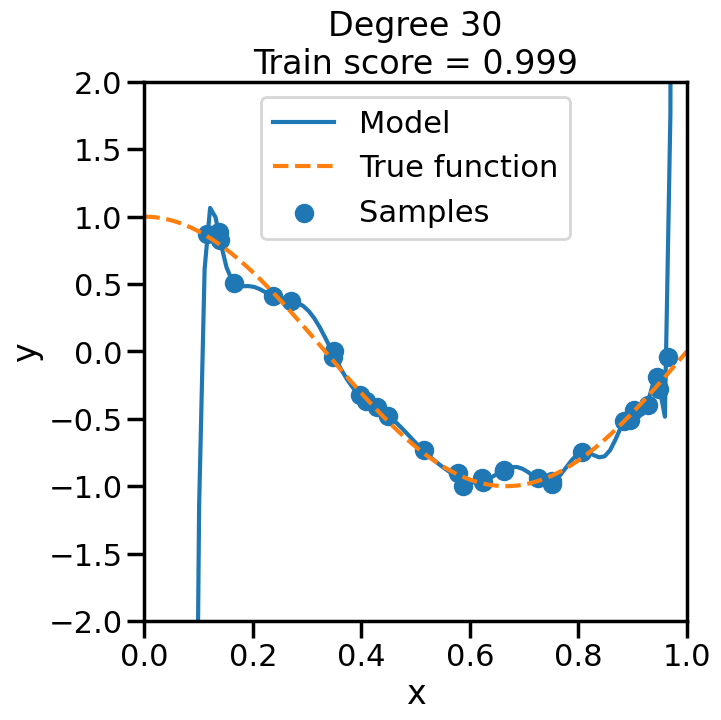

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Here is a list of different degree polynomials to try out
degrees = [1,2,3,5,10,15,20,30]

# Generate samples of the true function + noise
X = np.sort(np.random.rand(n_samples))
noise_amount = 0.1
y = true_fun(X) + np.random.randn(n_samples) * noise_amount

# For each of the different polynomial degrees we listed above
for d in degrees:
    plt.figure(figsize=(7, 7)) # Make a new figure
    # Construct the polynomial features
    polynomial_features = PolynomialFeatures(degree=d,
                                             include_bias=False)
    # Construct linear regression model
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    # Now fit the data first through the 
    # polynomial basis, then do regression
    pipeline.fit(X[:, np.newaxis], y)
    
    # Get the accuracy score of the trained model
    # on the original training data
    score = pipeline.score(X[:, np.newaxis],y)

    # Plot the results
    X_plot = np.linspace(0, 1, 100)
    plt.plot(X_plot, pipeline.predict(X_plot[:, np.newaxis]), label="Model")
    plt.plot(X_plot, true_fun(X_plot), '--',label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    
    # Print the polynomial degree and the training
    # accuracy in the title of the graph
    plt.title("Degree {}\nTrain score = {:.3f}".format(
        d, score))
    plt.show()   

We can see that even though we are fitting a linear model every time, the behavior with respect to x is markedly non-linear. Moreover, we see some strange behavior as we increase the polynomial degree. What is going on here and why is it behaving in this way? To build some intuition, we can take a look at the learned weight coefficients, by accessing the `coef_` attribute of the fitted model:

In [5]:
linear_regression.coef_


array([ 4.29e+04, -6.41e+05,  4.46e+06, -5.47e+06, -1.61e+08,  1.50e+09,
       -7.03e+09,  2.01e+10, -3.46e+10,  2.83e+10,  9.52e+09, -3.50e+10,
        5.36e+08,  3.61e+10,  3.50e+09, -3.63e+10, -1.74e+10,  2.94e+10,
        3.42e+10, -1.02e+10, -4.27e+10, -1.74e+10,  3.46e+10,  4.11e+10,
       -1.48e+10, -5.44e+10,  1.25e+09,  6.96e+10, -5.11e+10,  1.14e+10])

What is going on here? To understand this, we need to understand something about how the model is optimizing error and how we might control this behavior.

## Regularization and Controlling Model Complexity

In the base case above, all the model is trying to do is minimize the Mean Squared Error (MSE) with respect to the training error, and with a sufficient number of parameters (polynomial features, in this case), it becomes possible to always achieve perfect accuracy (i.e., fit every point) in the training data. Unfortunately, as we can see, fitting the training data perfectly does not necessarily lead to a model that generalizes well to new data. To help us control this behavior, we can introduce the concept of **Regularization**, which is a way of penalizing overly complex models. Specifically, we can modify our cost function to be something like:

$$
Cost = Loss(w,D) + \Omega(w)
$$

where $\Omega(w)$ represents what we call a "Regularization" of the function or a "Penalty Term" The purpose of $\Omega(w)$ is to help us prevent the (otherwise complex) model from being overly complicated, by penalizing this complexity. There are many ways to do this that we will see later on, but one common way to do this for linear models is to penalize the **total weight** that you allow all of the $w_i$ to have. Specifically how one calculates this total weight turns out to matter a lot, and we shall see it return in later chapters and sections. But to get us started in un-packing how to do this, we first need to talk about what a [Norm](https://en.wikipedia.org/wiki/Norm_(mathematics)) is, how it relates to Linear Regression weights, and how it helps us perform Regularization.

### Norms and their relationship to Regularization
A Norm is a concept in mathematics that allows us to essentially measure length or size, typically of vectors. Any time you have tried to compute the distance between two points in space (say, by using the Pythagorean Theorem), or the magnitude of an applied Force vector, you have been using a Norm --- most likely the Euclidean Norm or Euclidean Distance. For example, for a vector $\mathbf{x}$ with $n$ dimensions, the Euclidean Norm looks like this:
$$
||\mathbf{x}||_2 = \sqrt{ x_1^2 + x_2^2 + \cdots x_n^2 }
$$
If you have ever had to compute the total Force Magnitude given its x and y components (for example, in Statics class), you have used the Euclidean Norm to do so. In that context, it served to take multiple components of a Force aggregate them in such a way as to tell you something about the **total force** -- by analogy, we will do the same thing here with linear regression, where each weight is like a component and we can use the Euclidean Norm to compute the total weight.

While Euclidean Norms may be quite useful or familiar to Engineers, it turns out that they are a special case of a much wider *family* of Norms called [*p-norms*](https://en.wikipedia.org/wiki/Lp_space#The_p-norm_in_finite_dimensions), which are defined as:
$$
||\mathbf{x}||_p = \left(|x_1|^p + |x_2|^p+\cdots + |x_n|^p\right)^{1/p} = \left(\sum_{i=1}^n \left| x_i \right|^p \right)^p
$$

Specifically, the Euclidean Norm is called the L2-norm, or sometimes just the 2-norm. To see why this is, just set $p=2$ in the above, and note how it corresponds to the Euclidean Norm that we all know and love. So, by setting $p$ to a number between $0$ and $\infty$, we can modify what the *total weight* means, and setting $p=2$ is the setting which we are all most familiar with. To get a visual sense of how norms vary, see below, which visualizes a line of "circle" of radius 1, but where the length of the line is determined by the p-norm. You will see that when p=2 this corresponds to what we are familiar with, but when p goes up or down things change.


In [6]:
from ipywidgets import interact, FloatSlider

# Define a function to compute and plot the p-norm unit ball in 2D
def plot_p_norm(p=2.0):
    # Avoid invalid p values
    if p <= 0:
        print("p must be > 0")
        return
    
    theta = np.linspace(0, 2*np.pi, 400)
    # Parametric form of p-norm unit circle
    x = np.cos(theta)
    y = np.sin(theta)
    
    # Normalize to p-norm = 1
    denom = (np.abs(x)**p + np.abs(y)**p)**(1/p)
    x_unit = x / denom
    y_unit = y / denom
    
    plt.figure(figsize=(5,5))
    plt.plot(x_unit, y_unit, label=f'p = {p:.2f}')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'Unit Ball in p-norm (p={p:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Interactive slider for p
interact(
    plot_p_norm,
    p=FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1, description='p')
)

interactive(children=(FloatSlider(value=2.0, description='p', max=10.0, min=0.1), Output()), _dom_classes=('wi…

<function __main__.plot_p_norm(p=2.0)>

For today, we will just focus on the L2-Norm, however we will revist norms again later where we will see how changing the one we are using can have positive or negative effects in certain circumstances. 

We will use the L2-Norm to help us penalize having linear regression models with really large weights, by essentially putting a cost on the total weight of the weight vector, where the total is measured by the L2-Norm. That is:
$$
Cost = \sum_{n=1}^{N}||y-w\cdot x||^2 + \alpha \cdot ||w||^2
$$
Where $\alpha$ is the price we pay for including more weight in the linear model. If it reduces our error cost enough to offset the cost of the increased weight, then that may be worth it to us. Otherwise, we would err on the side of using less weight overall.

This Regularization (i.e., increasing $\alpha$) essentially allows you to trade off bias and variance, as we will see below.

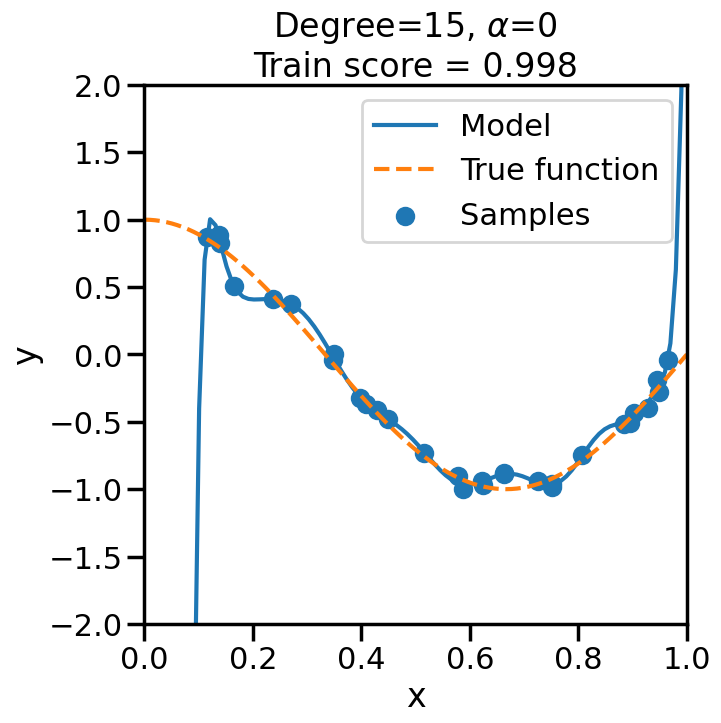

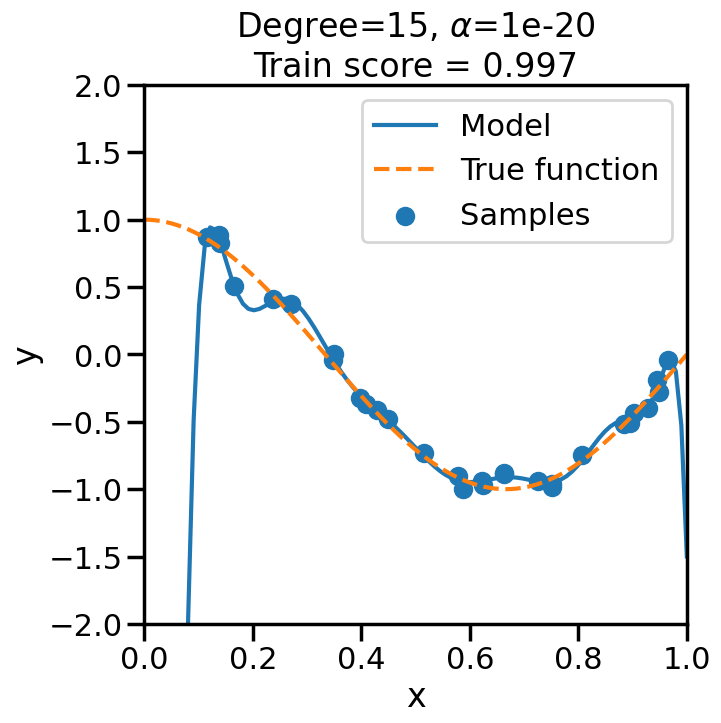

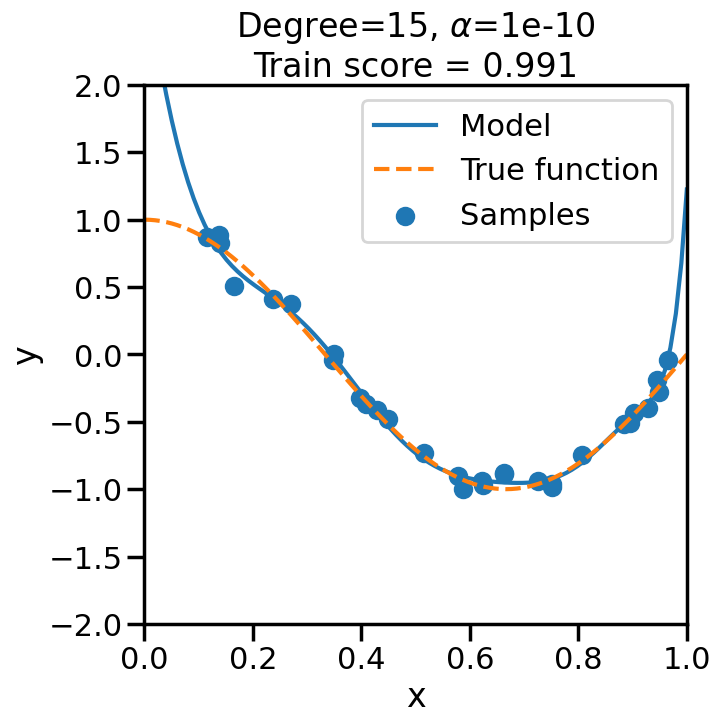

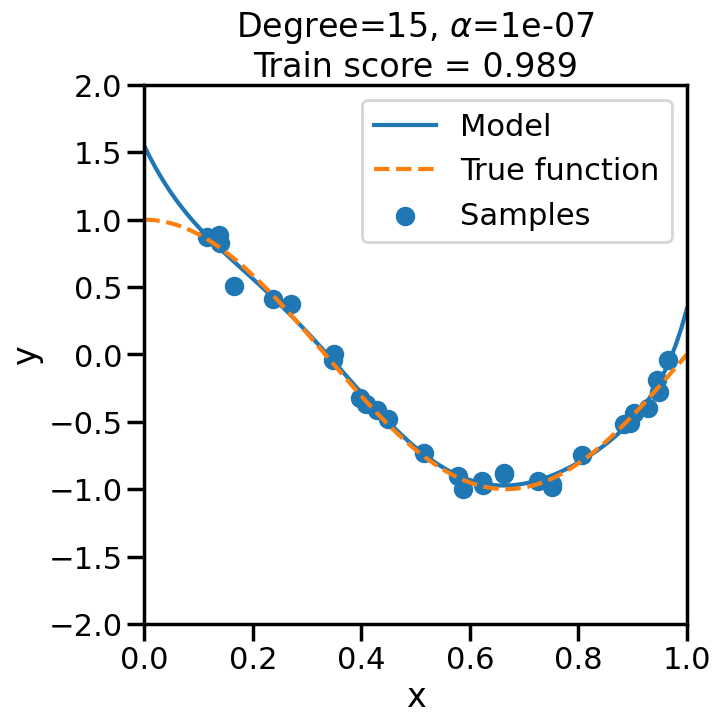

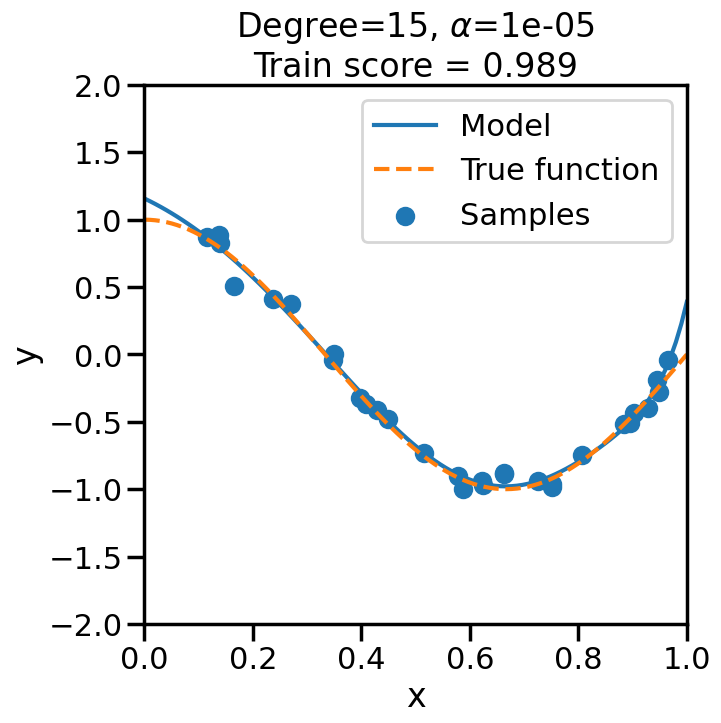

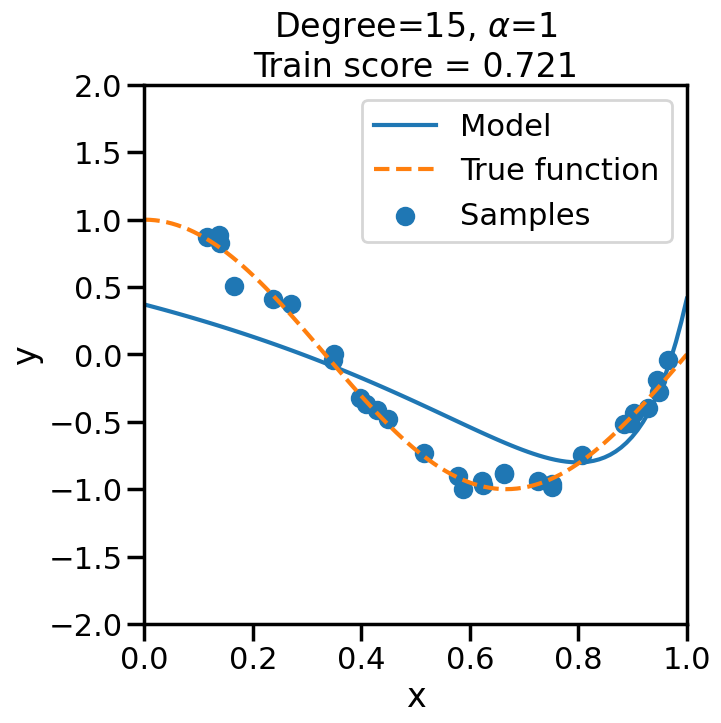

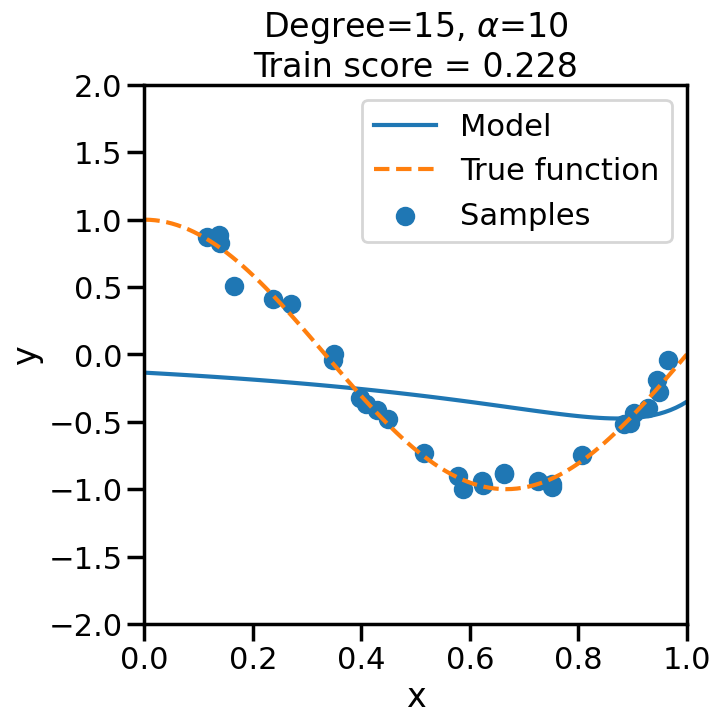

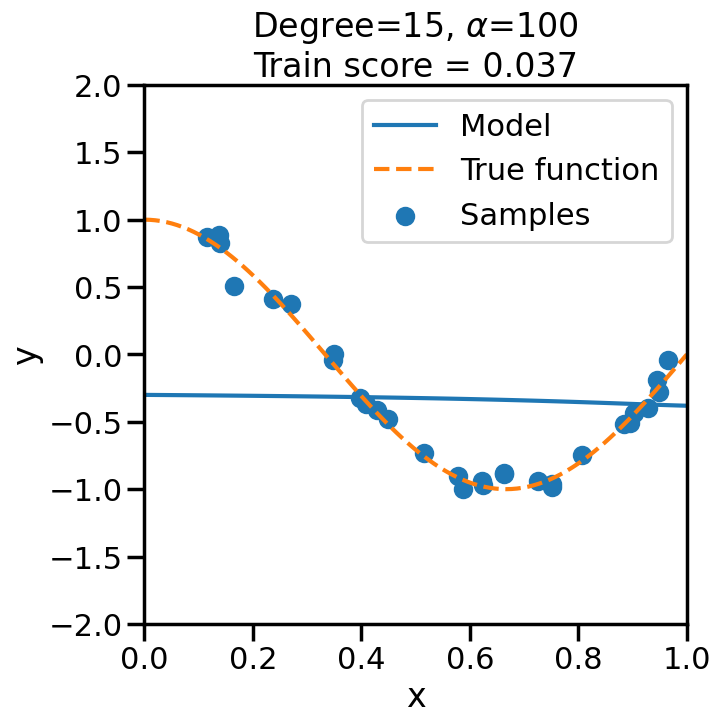

In [7]:
# Import Ridge Regression
from sklearn.linear_model import Ridge

# alpha determines how much of 
# a penalty the weights incur
alphas = [0, 1e-20, 1e-10, 1e-7, 1e-5, 1, 10, 100]

# For the below example, let's
# just consider a 15-degree polynomial
d=15
np.random.seed(100)

for a in alphas:
    plt.figure(figsize=(7, 7))
    polynomial_features = PolynomialFeatures(degree=d,
                                             include_bias=False)
    #linear_regression = LinearRegression() #<- Note difference with next line
    linear_regression = Ridge(alpha=a)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    # Fit model
    pipeline.fit(X[:, np.newaxis], y)
    # Get Training Accuracy
    score = pipeline.score(X[:, np.newaxis],y)

    # Plot things
    X_plot = np.linspace(0, 1, 100)
    plt.plot(X_plot, pipeline.predict(X_plot[:, np.newaxis]), label="Model")
    plt.plot(X_plot, true_fun(X_plot), '--',label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    
    plt.title("Degree={}, $\\alpha$={}\nTrain score = {:.3f}".format(
        d, a, score))
    plt.show()

## Examples of Other Commonly used Loss Functions in Linear Models
Thus far we have been discussing Linear Models in their most familiar context --- minimizing the Mean Squared Error (MSE) with respect to the training data, optionally with an L2 regularization on the weight vector:

$$
\mathcal{L}(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^N (y_i - \mathbf{w}^T \mathbf{x}_i)^2 + \alpha ||\mathbf{w}||_2^2
$$

For now, let us ignore the regularization term, and just focus on the Loss term. Why should we minimize the squared error?^[It turns out that there are good theoretical reasons for this, for example, that a Linear Model trained via an L2/MSE Loss is the Best Linear Unbiased Estimate (BLUE) of the Linear Model, according to the [Gauss-Markov Theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem), but, as we will see, there are other reasons to forgo these advantages.] Why not the absolute error or other possible loss functions? Let's explore a few of those options and then see, in practice, how they affect the learned linear model.

## Loss Functions for Regression

Beyond classical MSE, there are two main types of variants that are commonly used for regression problems:

- Robust Loss Functions, that minimize the quadratic effect of the MSE loss for very large errors. These are typically used to make the trained model less sensitive to outliers in the training data.
- Epsilon-Insensitive Loss functions, that ignore errors that are sufficiently small (within an $\epsilon$ margin). These are typically used to incur some advantages in terms of sparsity in the learned model (for example, in Support Vector Methods, which we will see later).

In reality, these two variants can be combined in different ways, which we will see reflected below, but as a summary, these are:

- Absolute Loss: $|y - \hat{y}|$
- Huber Loss: A squared loss for small errors, and then transitioning to an absolute loss for large errors.
- Epsilon-Insensitive Loss: A loss that is zero for errors up to $\epsilon$  and then uses absolute loss for larger errors.
- Squared Epsilon-Insensitive Loss: Similar to Epsilon-Insensitive Loss, but uses squared loss for errors larger than $\epsilon$.

Of course, you could imagine more complex variants and combinations of these properties, but these capture the main properties and benefits that we will see below.

In [8]:
def modified_huber_loss(y):
    if(abs(y)<1):
        return y**2
    else:
        return 2*abs(y)-1
mhuber = np.vectorize(modified_huber_loss)

eps = 0.7
def sq_esp_insensitive(y):
    if(abs(y)<eps):
        return 0
    else:
        return (abs(y)-eps)**2
sq_eps_ins = np.vectorize(sq_esp_insensitive)

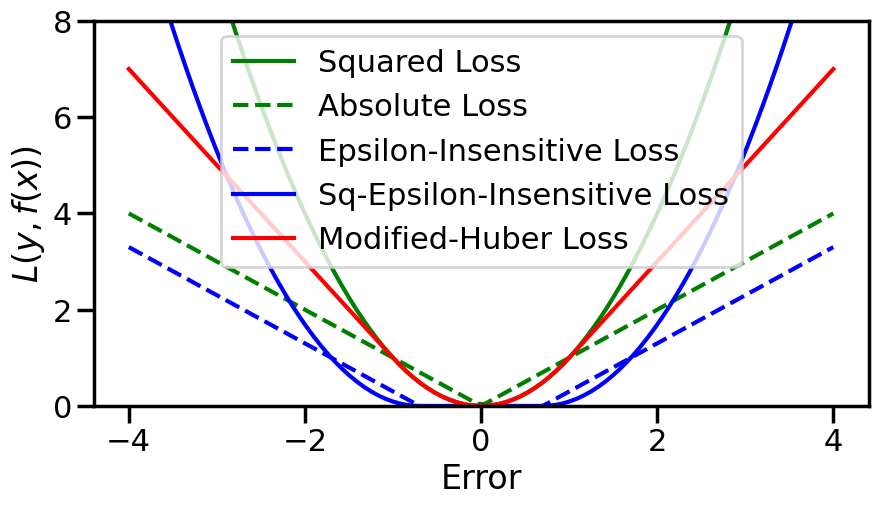

In [9]:
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)

plt.figure(figsize=(10,5))
plt.plot(xx, xx**2, 'g-',
         label="Squared Loss")
plt.plot(xx, abs(xx), 'g--',
         label="Absolute Loss")

plt.plot(xx, abs(xx)-eps, 'b--',
         label="Epsilon-Insensitive Loss")

plt.plot(xx, sq_eps_ins(xx), 'b-',
         label="Sq-Epsilon-Insensitive Loss")
plt.plot(xx, mhuber(xx), 'r-',
         label="Modified-Huber Loss")

plt.ylim((0, 8))
plt.legend(loc="upper center")
plt.xlabel("Error")
plt.ylabel("$L(y, f(x))$")
plt.show()

### Handling Outliers using Robust Loss Functions

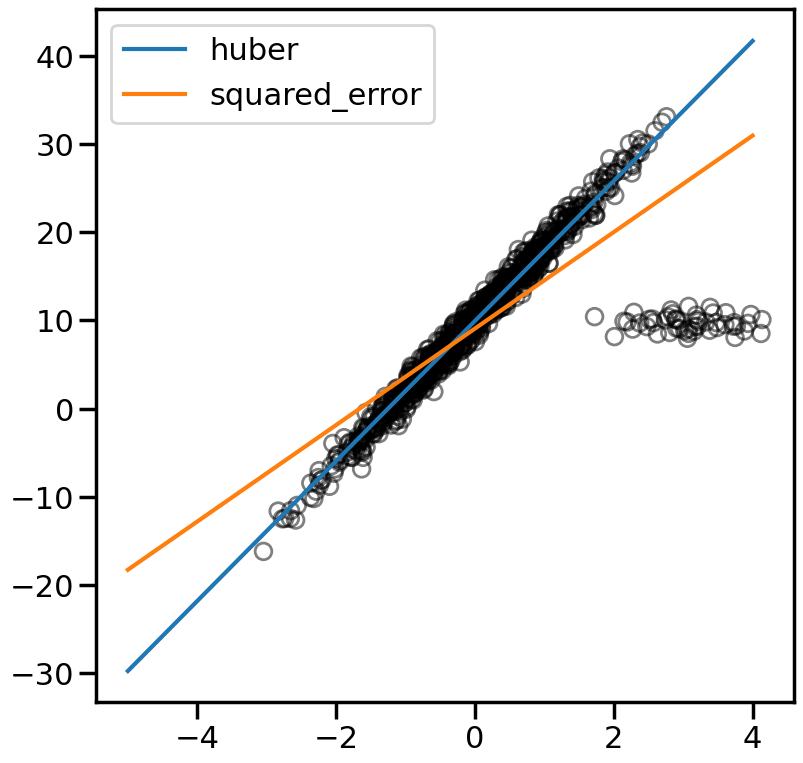

In [10]:
# Create some data with Outliers
n_samples = 1000
n_outliers = 50

Xr, yr, coef = make_regression(n_samples=n_samples, n_features=1,
                              n_informative=1, noise=10,
                              coef=True, random_state=0)
# Add outlier data
np.random.seed(0)
Xr[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
yr[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)
yr/=10
yr += 10

line_X = np.arange(-5, 5)
figure = plt.figure(figsize=(9, 9))

plt.scatter(Xr, yr,facecolors='None',edgecolors='k',alpha=0.5)

# Loss Options: huber, squared_error, epsilon_insensitive, squared_epsilon_insensitive
losses = ['huber', 'squared_error']
for loss in losses:
    model = SGDRegressor(loss=loss, fit_intercept=True, max_iter = 2000,
                     penalty='l2', alpha=.001, epsilon=1, tol=1e-3)
    model.fit(Xr, yr)

    # Predict data of estimated models
    line_y = model.predict(line_X[:, np.newaxis])
    plt.plot(line_X, line_y, '-', label=loss,alpha=1)

plt.axis('tight')
plt.legend(loc='best')
plt.show()

## Loss Functions for Linear Classification

Thus far we have only discussed Regression problems, where we are modeling a continuous output (e.g., $y=w^T\cdot x$). However, Linear Models can also be used for Classification problems, where the output is discrete (e.g., $y \in \{0,1\}$ or $y \in \{-1,1\}$). A naive approach to handling this, would be to just train a regression model as per before, but then just threshold the output at some value to derive the class label. For example, we can take the below binary data:

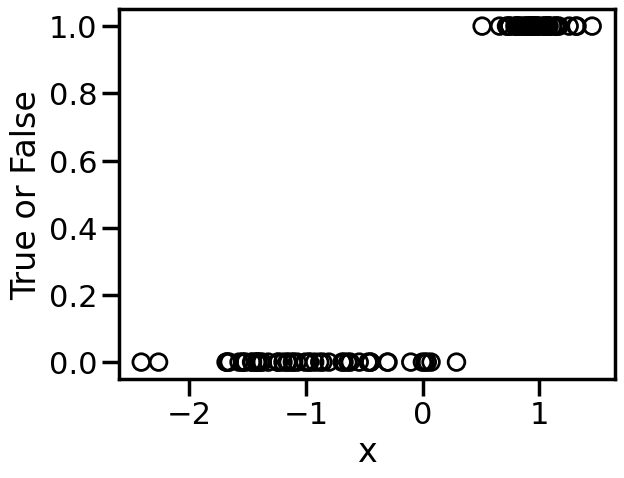

In [11]:
from sklearn.datasets import make_classification
X, y = make_classification(n_features=1, n_redundant=0, 
                           n_informative=1,
                           random_state=1,
                           n_clusters_per_class=1,
                           flip_y=0.0, class_sep=1)
plt.figure()
plt.xlabel('x')
plt.ylabel('True or False')
plt.scatter(X,y,marker='o',facecolors='none',edgecolors='k')
plt.show()

and then fit a regular linear model to this:

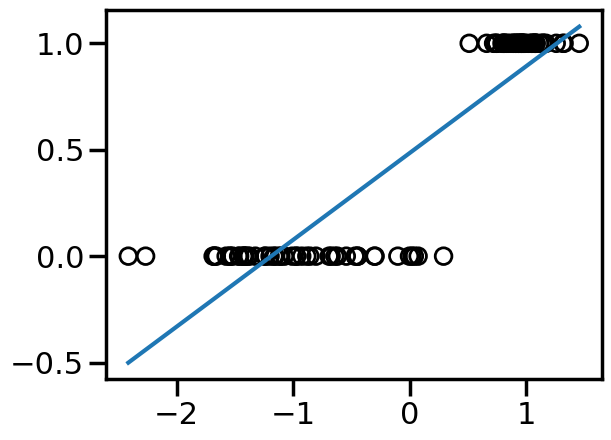

In [12]:
model = SGDRegressor(loss='squared_error', fit_intercept=True, max_iter = 2000,
                     penalty='l2', alpha=.001, epsilon=1, tol=1e-3)
model.fit(X, y)
Xp = np.linspace(X.min(),X.max(),100)
Xp = Xp[:, np.newaxis]
plt.figure()
plt.scatter(X,y,marker='o',facecolors='none',edgecolors='k')
plt.plot(Xp,model.predict(Xp))
plt.show()


We can see from the above that this is not entirely what we want -- for example, just setting the class cutoff at 0.5 would not produce a classification boundary that would be optimal. In contrast, we can modify the loss function to more accurately project the $w^T\cdot x$ linear model into a classification context.

We do this by modifying the loss function from Mean Squared Error to something like:
$$
y_i\cdot(w\cdot x_i)
$$
where $y_i = \pm 1$ such that if $y_i$ and $w\cdot x_i$ point have similar signs, then the decision function is positive, otherwise it is negative.

With this change, we are now interested primarily with how the behavior of the loss function when we are in the negative regime (i.e., misclassified points):

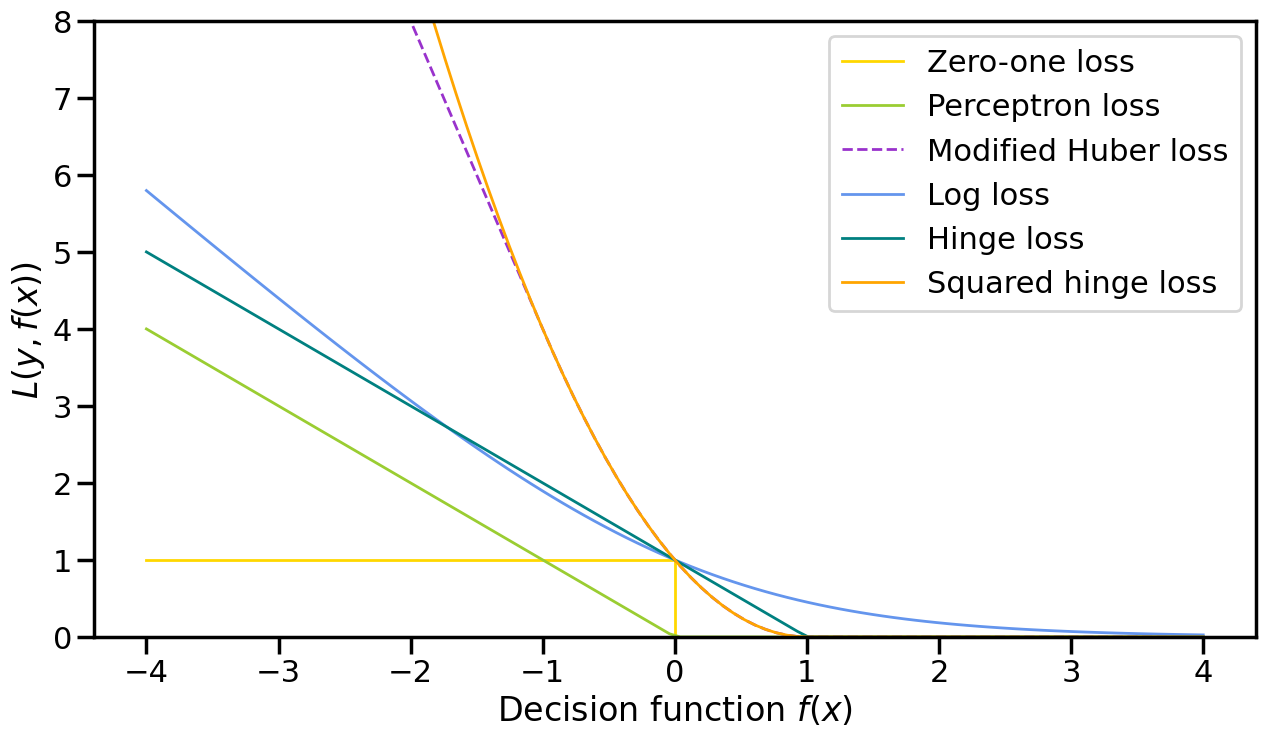

In [13]:
# From: http://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html
def modified_huber_loss(y_true, y_pred):
    z = y_pred * y_true
    loss = -4 * z
    loss[z >= -1] = (1 - z[z >= -1]) ** 2
    loss[z >= 1.] = 0
    return loss


xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2
fig = plt.figure(figsize=(15,8))
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], color='gold', lw=lw,
         label="Zero-one loss")
plt.plot(xx, -np.minimum(xx, 0), color='yellowgreen', lw=lw,
         label="Perceptron loss")
plt.plot(xx, modified_huber_loss(xx, 1), color='darkorchid', lw=lw,
         linestyle='--', label="Modified Huber loss")
plt.plot(xx, np.log2(1 + np.exp(-xx)), color='cornflowerblue', lw=lw,
         label="Log loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), color='teal', lw=lw,
         label="Hinge loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0) ** 2, color='orange', lw=lw,
         label="Squared hinge loss")
plt.ylim((0, 8))
plt.legend(loc="upper right")
plt.xlabel(r"Decision function $f(x)$")
plt.ylabel("$L(y, f(x))$")
plt.show()

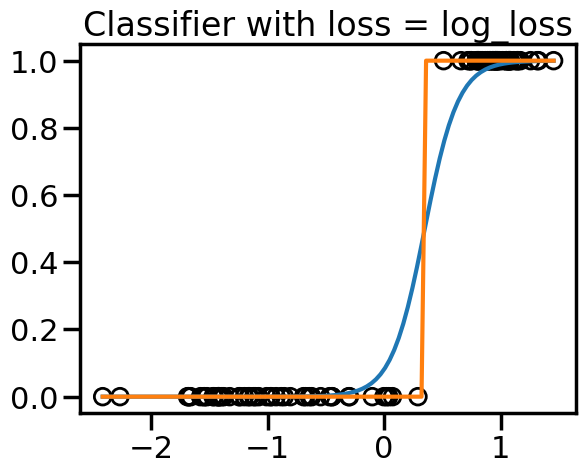

In [14]:
####### Try Changing the Below ######
#loss = 'squared_error'
loss = 'log_loss'
#loss = 'hinge'
#####################################

model = SGDClassifier(loss=loss, fit_intercept=True, max_iter = 2000,
                     penalty='l2', alpha=.001, epsilon=1, tol=1e-3)
model.fit(X, y)
Xp = np.linspace(X.min(),X.max(),100)
Xp = Xp[:, np.newaxis]
plt.figure()
plt.scatter(X,y,marker='o',facecolors='none',edgecolors='k')
try:
    plt.plot(Xp,model.predict_proba(Xp)[:,1],label='probability')
except:
    pass
plt.plot(Xp,model.predict(Xp))
plt.title("Classifier with loss = {}".format(loss))
plt.show()

We can also try this with 2D data to get a better sense of how some of the other loss functions behave:

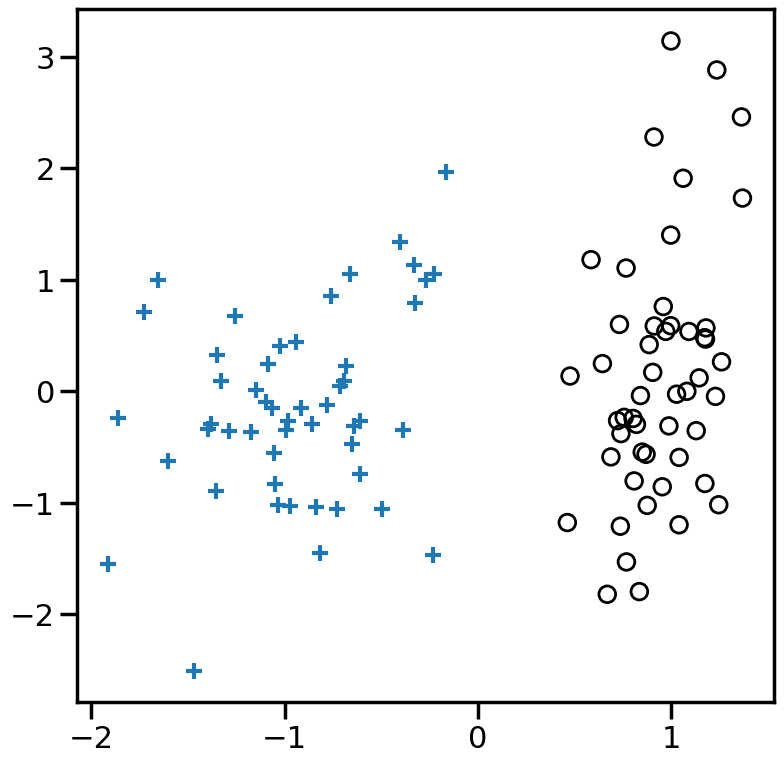

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification


X, y = make_classification(n_features=2, n_redundant=0, 
                           n_informative=2,
                           random_state=1,
                           n_clusters_per_class=1,
                           flip_y=0.0, class_sep=0.7)

linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

# Change: try 0,1, or 2
ds = datasets[2]

X, y = ds
X = StandardScaler().fit_transform(X)

plt.figure(figsize=(9, 9))
plt.scatter(X[y==1,0],X[y==1,1],marker='+')
plt.scatter(X[y==0,0],X[y==0,1],marker='o',facecolors='none',edgecolors='k')
plt.show()

::: {.callout-tip appearance="default"}
### Experiment: Effect of Linear Model Classification Losses
In the below experiment, try modifying the different classification loss functions and re-running the model. You will see a dark solid line representing the decision boundary, and dashed lines representing where the decision boundary is +1 or -1. What do you notice?:

- For the perceptron loss, what behavior do you observe if you re-run this model multiple times? Why do you observe this behavior?
- Comparing the hinge loss to the perceptron loss, the loss functions look remarkably similar, yet they have very different behavior in the model. Why do you think this is?
- Comparing the squared error versus log loss versus hinge, what sorts of differences in behavior do you observe? Thinking about the location of the decision boundary and the shape of the loss functions, why do you think they behave differently?

:::

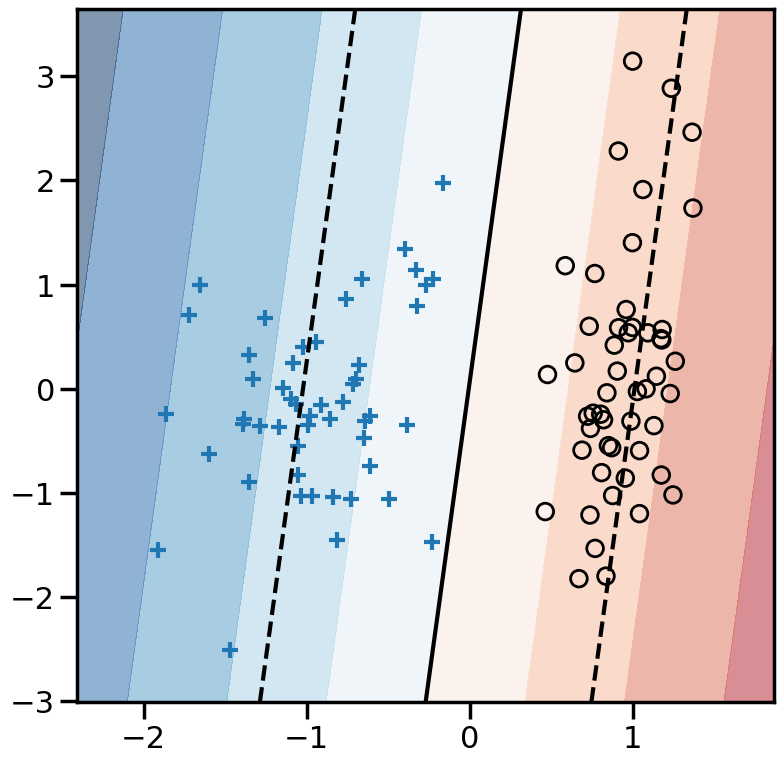

In [16]:
from sklearn.svm import LinearSVC

# Try modifying these:
#====================
loss = 'squared_error'
#loss = 'perceptron'
#loss = 'log_loss'
#loss = 'hinge'
#loss = 'modified_huber'
#loss = 'squared_hinge'

# Also try the effect of Alpha:
# e.g., between ranges 1e-20 and 1e0
#=============================
alpha=1e-3

# You can also try other models by commenting out the below:
model = SGDClassifier(loss=loss, fit_intercept=True,
                      max_iter=2000,tol=1e-5, n_iter_no_change =100,
                      penalty='l2',alpha=alpha) 
# If you would like to compare the SGDClassifier with hinge loss to LinearSVC, you can uncomment the below:
#model = LinearSVC(loss='hinge',C=1e3)
model.fit(X, y)

plt.figure(figsize=(9, 9))

h=0.01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(model, "decision_function"):
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

vmax = max(abs(Z.min()),abs(Z.max()))
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z, cmap=cm, alpha=.5, vmax = vmax, vmin = -vmax)
levels = [-1.0, 0.0, 1.0]
linestyles = ['dashed', 'solid', 'dashed']
colors = 'k'
plt.contour(xx, yy, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[y==1,0],X[y==1,1],marker='+')
plt.scatter(X[y==0,0],X[y==0,1],marker='o',facecolors='none',edgecolors='k')
plt.show()

## Penalty Functions: Example of How $L_p$ Penalty Changes Loss Optima

OK, so we have seen how different loss functions can affect the learned linear model. But what about the penalty function? How does changing the penalty function affect the learned model? Let's explore this with a simple example by again returning to fitting a line. In this case, we will fit an actual "line" to the data, by which I mean:

$$
y= w_0 + w_1 \cdot x = \mathbf{w}^T \cdot \mathbf{x}
$$



In [17]:
# Generate noisy data from a line

######################
# Change Me!
w1_true = 5
w0_true = 2
noise = 0.001
#################

true_func = lambda x: w1_true*x+w0_true

num_samples = 50
x = (np.random.rand(num_samples)-0.5)*20
y = true_func(x)+np.random.normal(scale=noise,size=num_samples)

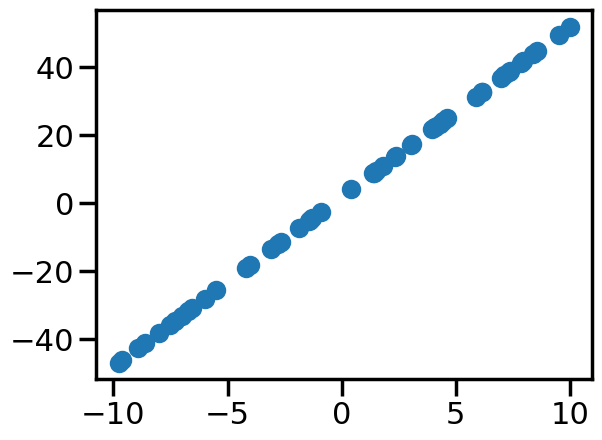

In [18]:
plt.figure()
plt.scatter(x,y)
plt.show()

In this case, since we have very little noise (although you can play with this if you would like), you can see that if we put in the true intercept and slope, we get zero (or close to zero) training objective.

In [ ]:
#| code-fold: false
from numpy.linalg import norm
def loss(a,b,alpha,order=2):
    return np.average((y - (a*x+b))**2) + alpha*norm([a,b],ord=order)

#example
print(f"Objective: {loss(a=5,b=2,alpha=0)}")

Objective: 1.3389235788421472e-06


This tells us the objective at the true parameters, but now let's visualize how the total objective (training error + penalty) varies as we change the parameters. To do this, we can compute the total objective over a grid of possible values for $w_0$ and $w_1$, and then plot the contours of this objective function:

In [28]:
A, B = np.meshgrid(np.linspace(-10, 10, 201), np.linspace(-10, 10, 201))
N,M = A.shape
floss = np.vectorize(loss)

def generate_new_data(a=5,b=5):
    x = (np.random.rand(num_samples)-0.5)*20
    #y = true_func(x)+np.random.normal(scale=1,size=num_samples)
    y = a*x+b+np.random.normal(scale=1,size=num_samples)
    return x,y

def generate_z_grid(alpha,order):
    Z_noalpha = floss(A.flatten(),B.flatten(),0).reshape((N,M))
    alpha=alpha
    Z = floss(A.flatten(),B.flatten(),alpha,order)
    min_ind = np.argmin(Z)
    Amin = A.flatten()[min_ind]
    Bmin = B.flatten()[min_ind]
    Z = Z.reshape((N,M))
    return Z_noalpha, Z, Amin, Bmin

get_levels = lambda z: [np.percentile(z.flatten(),i) for i in [0,0.5,1,2,5,10,15,30,40,50,75,95,100]]
#levels = [np.percentile(allz,i) for i in [0,0.5,1,2,5,10,15,30,40,50,75,95,100]]
#levels = [np.percentile(allz,i) for i in np.logspace(-2,3,10,base=3)]

def plot_objective(alpha=0,order=2):
    Z_noalpha, Z, Amin, Bmin = generate_z_grid(alpha,order)
    plt.figure(figsize=(7,7))
    plt.vlines(0,-10,10,alpha=0.25,colors='r',linestyles='solid')
    plt.hlines(0,-10,10,alpha=0.25,colors='r',linestyles='solid')
    plt.contour(A,B,Z_noalpha,10,levels=get_levels(Z_noalpha),linestyles='solid',cmap='Greys_r',alpha=0.05)
    plt.contour(A,B,Z,10,levels=get_levels(Z),linestyles='solid',cmap='Greys_r',alpha=0.5)
    plt.scatter([0],[0],marker='D',s=50,c='r')
    plt.scatter([w1_true],[w0_true],marker='*',s=400)
    plt.scatter([Amin],[Bmin])
    plt.xlabel('a')
    plt.ylabel('b')
    plt.title('Optima: a={:.2f}, b={:.2f}'.format(Amin,Bmin))
    plt.show()

In [ ]:
#| code-fold: false
interact(plot_objective,
         alpha=np.logspace(-2,5,8),
         order=FloatSlider(min=0,max=10,step=0.1,continuous_update=False,value=2.0))

interactive(children=(Dropdown(description='alpha', options=(np.float64(0.01), np.float64(0.1), np.float64(1.0…

<function __main__.plot_objective(alpha=0, order=2)>

Here we can see the true optimal parameters as a blue star, the objective function contours as dark gray lines, and the red diamond shows the point where both weights are zero. The orange circle shows the minimum point of the objective function. If you increase the value of alpha in the drop down, this will increase the penalty weight, and you can see how both the objective and the optimal point change. Moreover, you can change the p-norm order in the penalty to see what effect this has on the total objective function.

::: {.callout-tip appearance="default"}
### Experiment: How do the different penalty terms affect the Objective Function and the optimal weight?
Try modifying the following:

- As you increase the penalty weight under the L2 norm, how does the objective landscape change? 
- If you use a p-order that is less than 2, how does this alter the objective landscape?
- The L1 norm is known to induce sparsity in the optimal weights. Do you observe this in the objective landscape? Why or why not?
- Different types of regularization within the p-norm family are often referred to as "Shrinkage" operators. Why do you think this is the case, based on what you observe?
- If my goal is to induce sparsity, it would make sense to consider the L0 norm, which just counts the number of non-zero entries in a vector. Based on the plots below, why won't this work?

:::

To help visualize the experiment above, let's try plotting, for different norm orders, the path that the coefficients take as we set alpha = 0 (no regularization) to a large number (essentially fully regularized). Now the light green contour represents just the contribution to the objective from the training error (no regularization), and the light gray contour shows the contribution from the penalty term (no training error). The blue line shows how the optimal weight changes as we increase the penalty weight from 0 to a large number.^[Note how I can visually find the optimal weight by fixing a given iso-contour of the regularization term (the gray lines) and then finding the point along that iso-contour where the green contour is minimized.]

In [22]:
from scipy.optimize import fmin
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

alpha_range = np.logspace(-1,5,14)
order_range = [0,0.25,.5,.75,1,1.5,2,3,5,10,20,100]

Al = len(alpha_range)
Ol = len(order_range)
results = np.zeros((Al,Ol,2))

for j,o in enumerate(order_range):
    prev_opt = [5,5]
    for i,a in enumerate(alpha_range):
        f = lambda x: loss(x[0],x[1],alpha=a,order=o)
        x_opt = fmin(f,prev_opt,disp=False)
        results[i,j] = x_opt
        prev_opt = x_opt

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


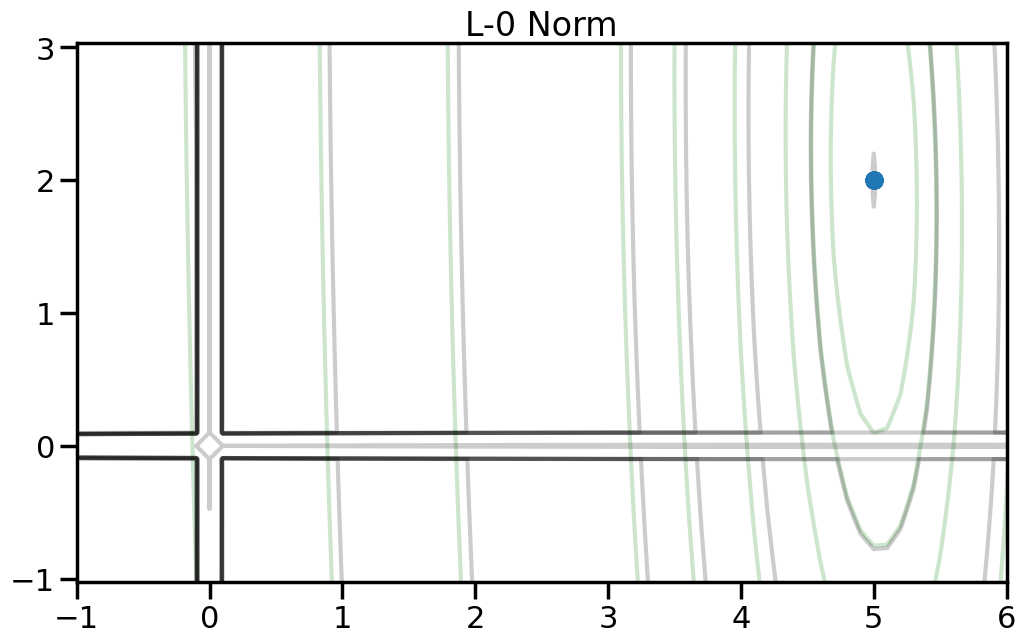

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


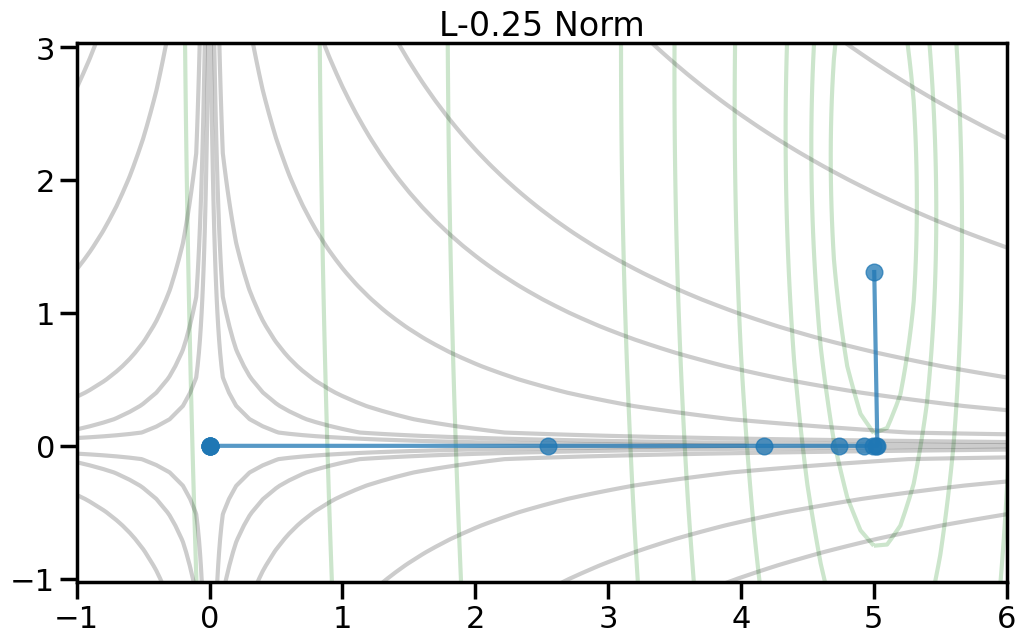

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


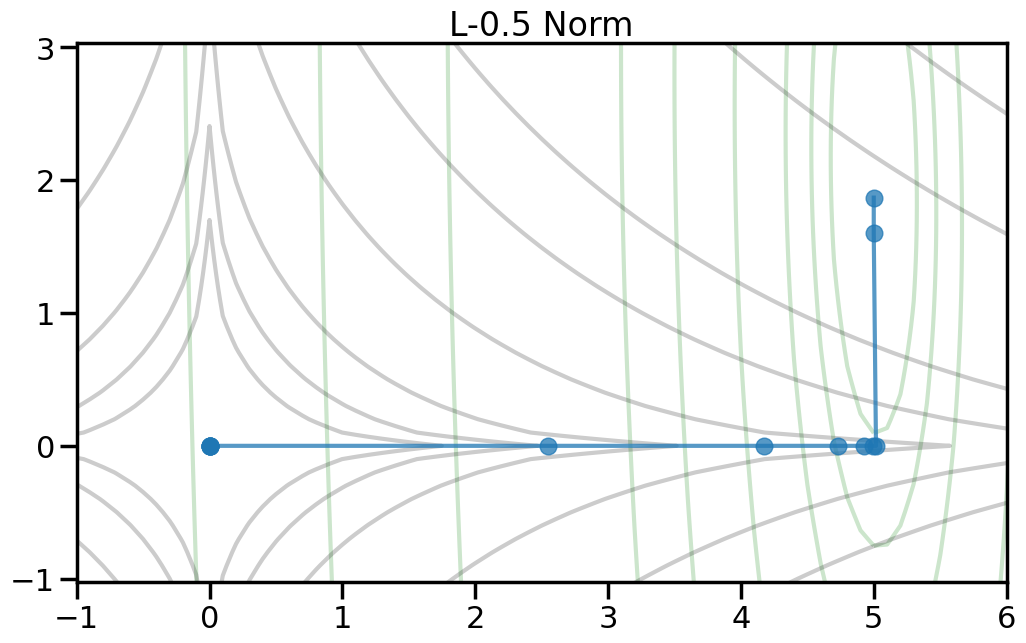

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


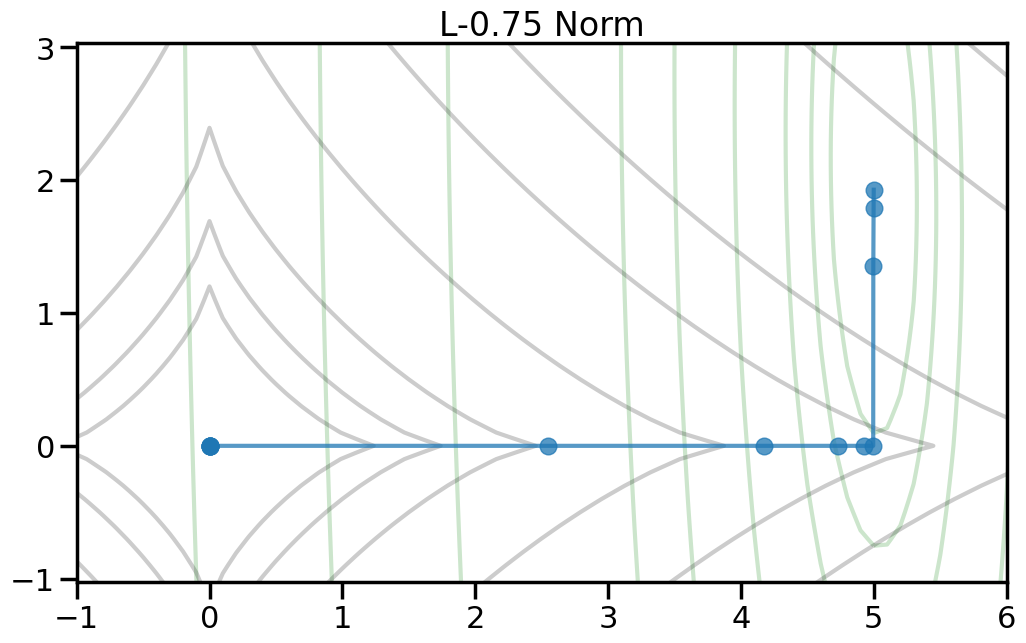

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


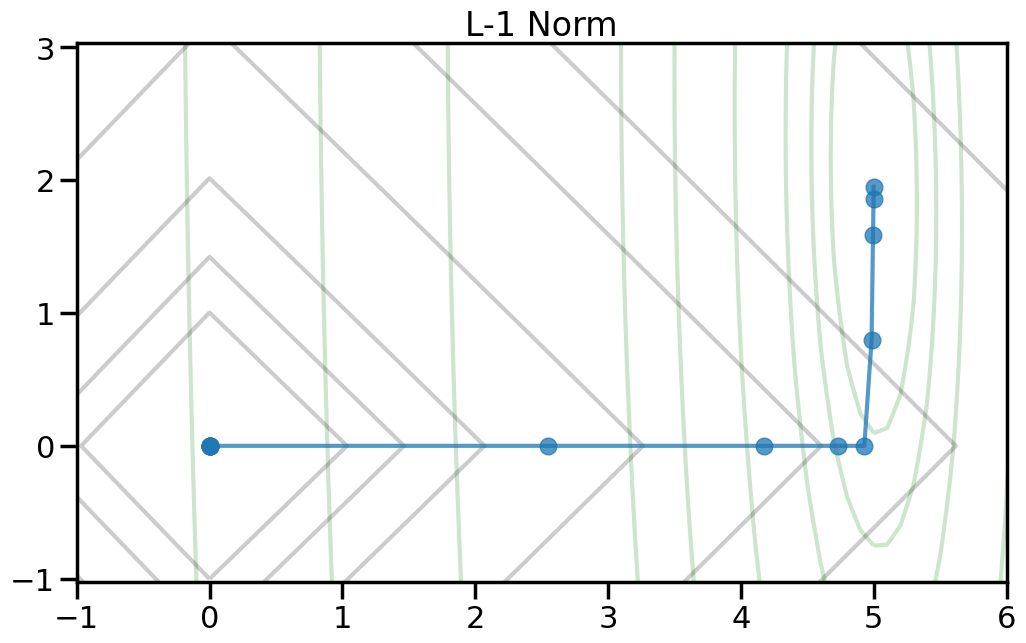

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


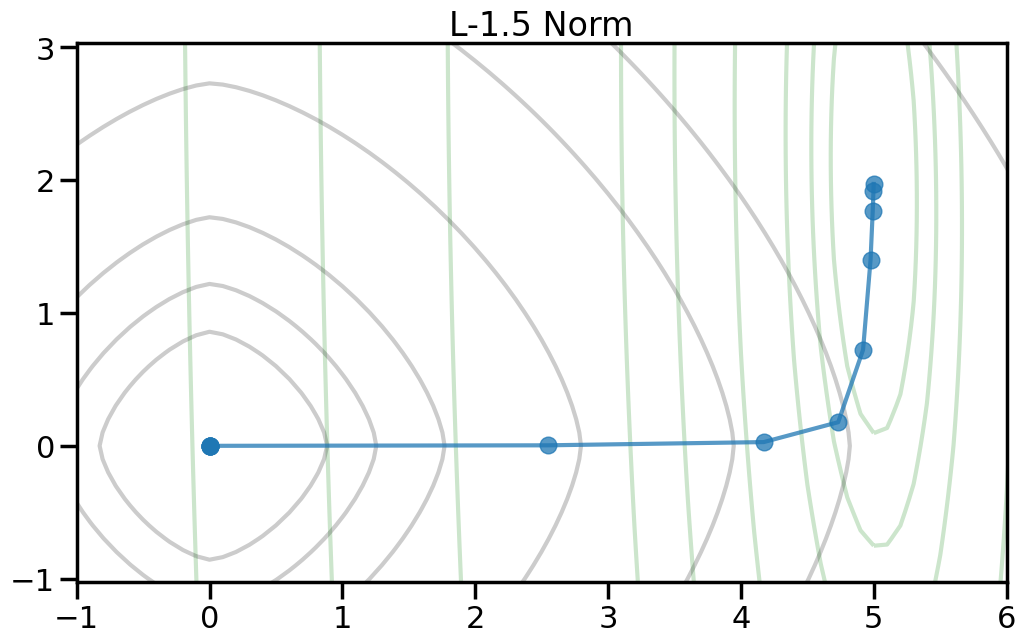

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


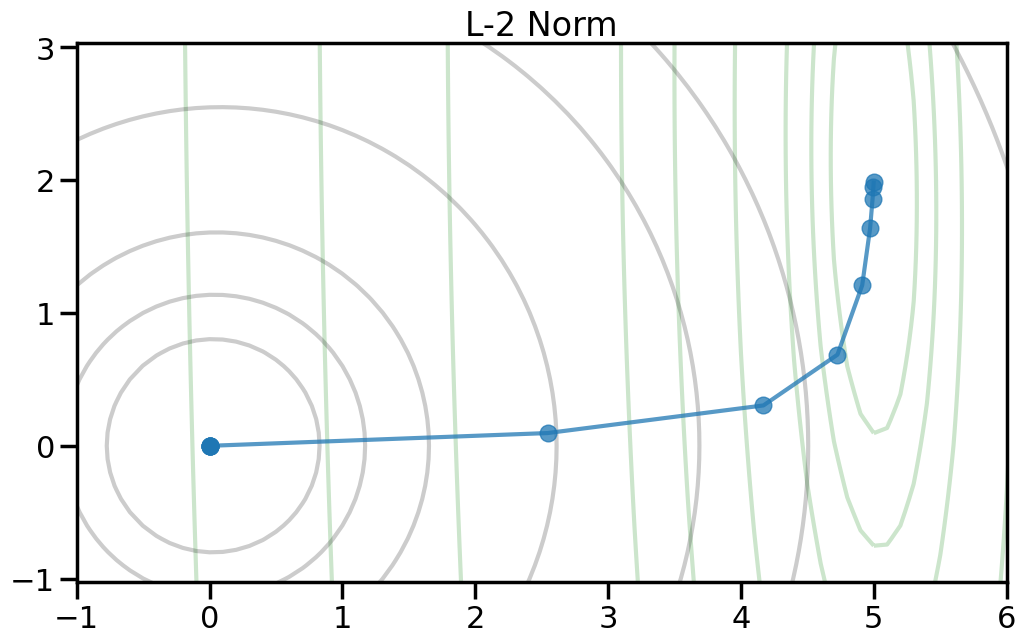

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


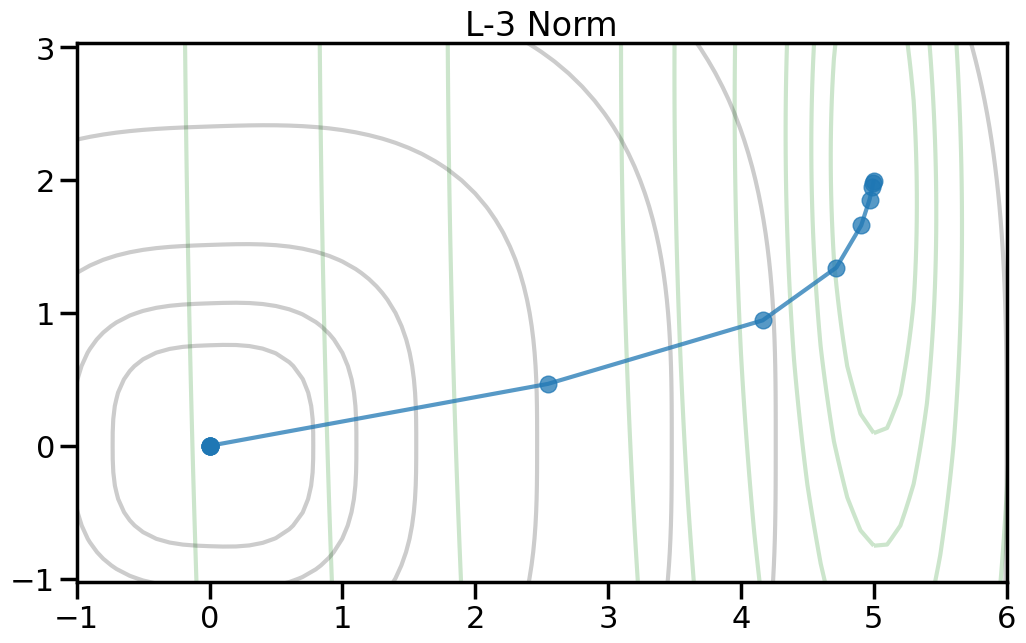

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


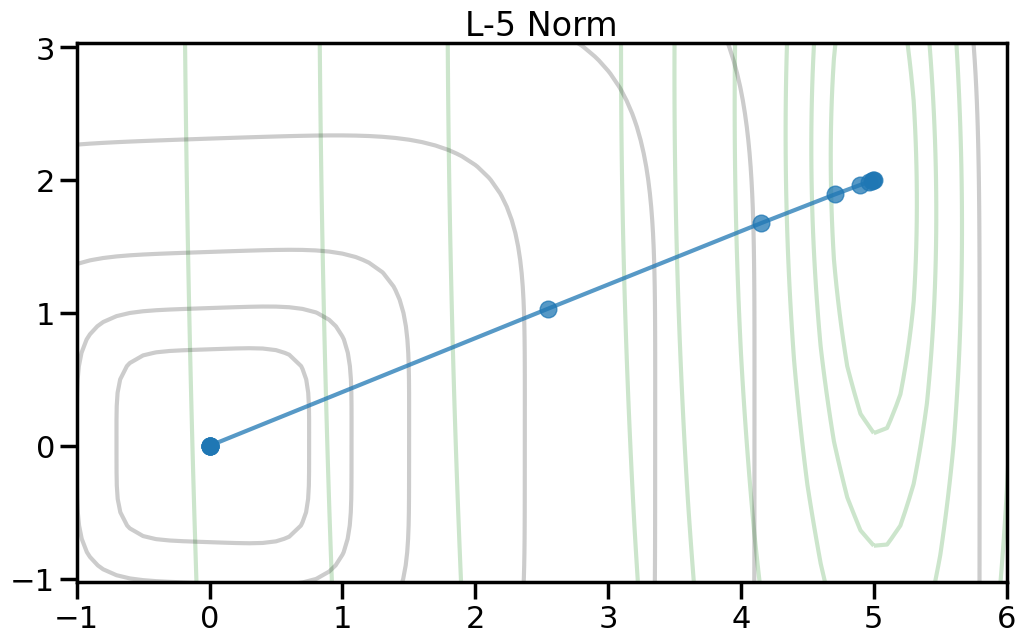

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


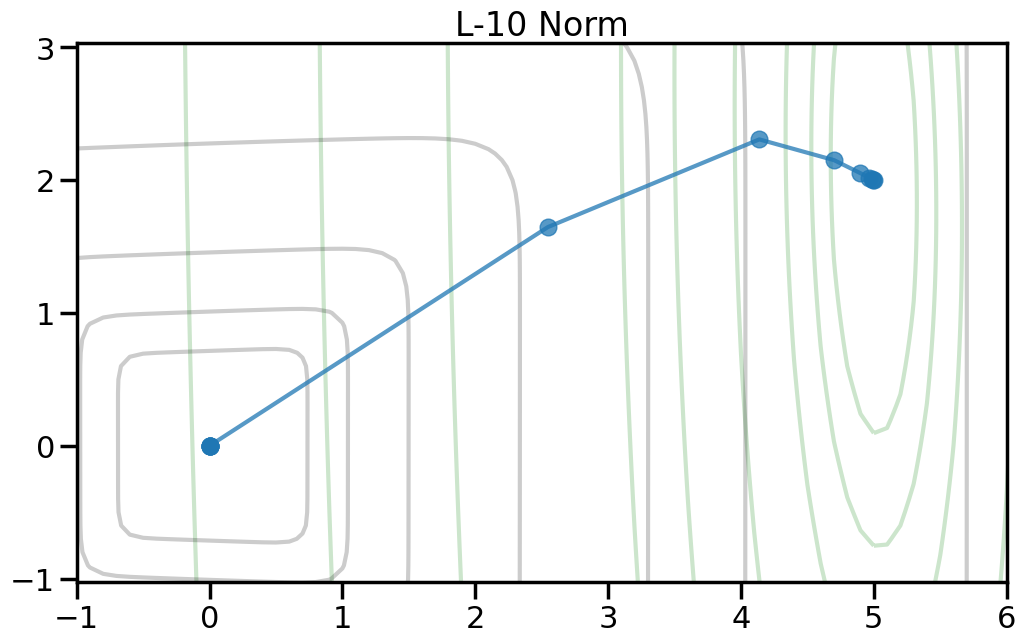

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


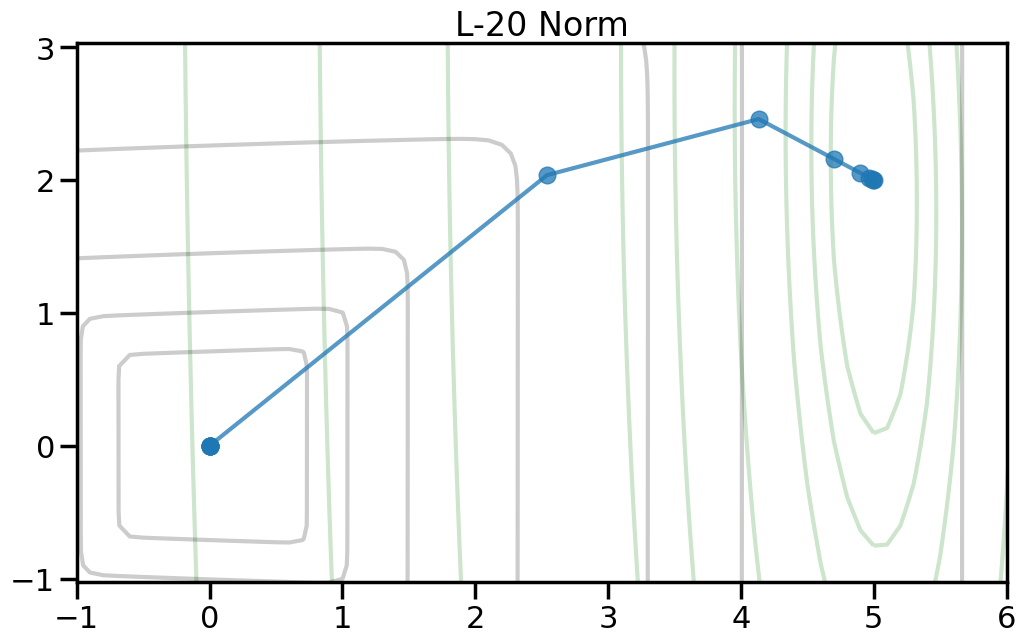

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


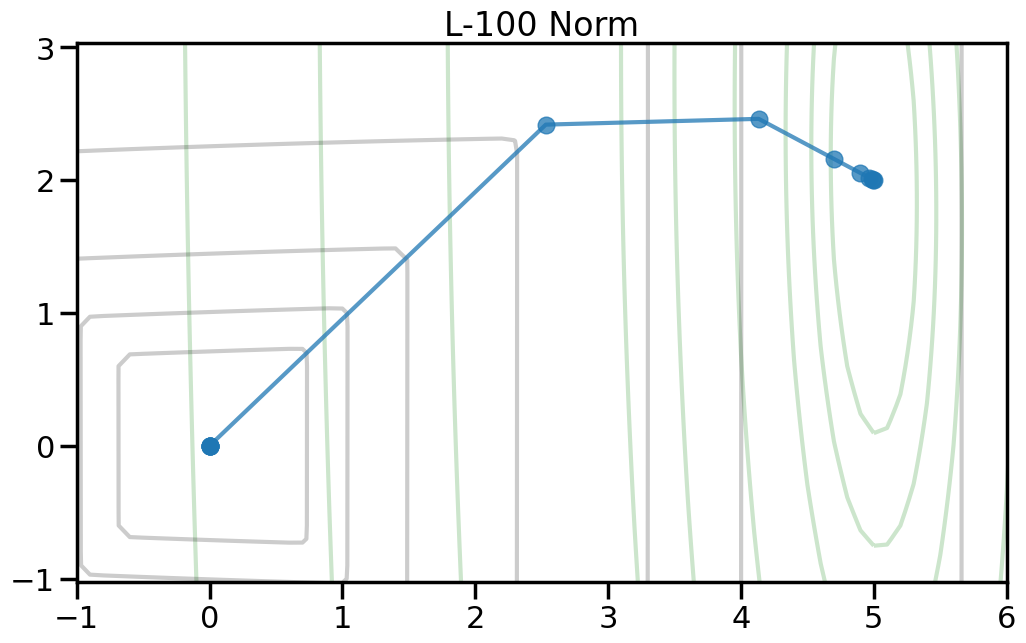

In [23]:
for j,o in enumerate(order_range):
    fig = plt.figure(figsize=(12,7))
    Z_noalpha, Z, Amin, Bmin = generate_z_grid(10000,o)
    plt.contour(A,B,Z_noalpha,10,levels=get_levels(Z_noalpha),linestyles='solid',alpha=0.2,colors='g')
    plt.contour(A,B,Z,10,levels=get_levels(Z),linestyles='solid',alpha=0.2,colors='k')
    plt.plot(results[:,j,0],results[:,j,1],marker='o',alpha=0.75)
    plt.title('L-{} Norm'.format(o))
    plt.axis('equal')
    plt.xlim([-1,6])
    plt.ylim([-1,3])
    plt.show()

## Summary of How to Select a Loss or Penalty function
In class, we reviewed a couple of different forms of loss functions and penalty functions and talked a bit about the criteria for selecting them. Below is a very short summary of these.

### Loss Functions for Regression:
* If you have no prior knowledge of the function or data, then selecting an L2 type loss (like the Mean Squared Error) is reasonable. When data nicely behaves w.r.t. a linear model (e.g., features are uncorrelated, errors in the linear model are uncorrelated, have equal variances, and expected error of zero around the linear model, etc.) then a Linear Model with an L2 Loss is the Best Linear Unbiased Estimate (BLUE) according to the [Gauss-Markov Theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem).
* If you have reason to believe that the data will have outliers or otherwise need to be robust to spurious large samples, then L2 loss will not be robust to this (as we saw in Lecture). For this, moving to an L1 type loss (like an Absolute Loss or Huber loss) will make the model less sensitive to outliers. It is one approach to handling [Robust Regression](https://en.wikipedia.org/wiki/Robust_regression).
* If you need to have the model's loss be dominated only by a handful of points/data as opposed to all of the data, then epsilon-insensitive loss is appropriate since many points well-fit by the model will have "zero" loss. For things like Linear Models, this has limited usefulness right now. However, when we "kernalize" Linear models in "Kernels" week, you will see that this is a big deal, and it is what gives rise to the "Support Vector" part of "Support Vector Machines". Specifically, decreasing epsilon towards zero increases the number of needed Support Vectors (can be a bad thing), and increasing epsilon can decrease the number of needed Support Vectors (can be a good thing). This will make more sense in a few week's time.

### Loss Functions for Classification:
* Zero-One loss sounds nice, but is not useful in practice, since it is not differentiable.
* [Perceptron loss](https://en.wikipedia.org/wiki/Perceptron), while of historical importance, is not terribly useful in practice, since it does not converge to a unique solution and an SVM (i.e., Hinge Loss below) has all of the same benefits.
* If you need a simple linear model which outputs actual probabilities (like, 95% sure the component has failed), then the log-loss does this, via [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) and allows you to calculate classification probabilities in closed form.
* If you want something that [maximizes the margin](https://en.wikipedia.org/wiki/Margin_(machine_learning)) of the classifier, then the Hinge Loss can get close to this. It is the basis of [Linear Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine#Linear_SVM)

### Penalty Terms (Lp Norms) for Linear Models:
* $L_2$ Norm penalties on the weight vector essentially "shrink" the weights towards zero as you increase the penalty weight. Adding this kind of penalty to a linear model has different names, depending on which community of people you are talking with. Some of these other names are: (1) [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), (2) Ridge Regression, (3) $L_2$ Shrinkage Estimators, or (4) Gaussian Weight Priors. I find looking at the penalty term itself more helpful at understanding the effects rather than memorizing the different names.
* $L_0$ Norm penalties, while conceptually interesting since they essentially "count" entries in the weight vector, are not practically useful since they are not differentiable and are thus difficult to optimize.
* $L_1$ Norm penalties are a compromise between $L_2$ and $L_0$ in that they promote sparsity in the weights (some weights will become zero) but are (largely) differentiable, meaning that you can meaningfully optimize them (unlike $L_0$). Shrinking certain weights to zero in this way can be useful when (1) you are in the $n \ll p$ regime (many more features than data points) where the model is underdetermined and (2) you want some degree of model interpretability (it sets many weights to zero). Some of these other names for this kind of linear regression with this penalty are the [LASSO (least absolute shrinkage and selection operator)](https://en.wikipedia.org/wiki/Lasso_(statistics)). 
* $L_\infty$ (where p is really large) essentially penalize the size of the biggest element of the weight vector (w). While there are some niche instances where this kind of norm is useful for a Loss function (e.g., [Chebyshev Regression](https://en.wikipedia.org/wiki/Minimax_approximation_algorithm)), I have rarely seen meaningful use cases in practice where this makes sense as a penalty term for the weight vector.
* Combinations of penalties. For example, a common combination is combining both an $L_2$ and $L_1$ penalty on the weights, as in: $\Omega(w) = \alpha ||w||_2 + \beta ||w||_1$. This particular combination is called ["Elastic Net"](https://en.wikipedia.org/wiki/Elastic_net_regularization) and exhibits some of the good properties of $L_2$ penalities with the sparsity inducing properties of $L_1$ regularization.